In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import h5py
from tqdm import tqdm
import numpy as np
import os, glob
plt.style.use("science")

In [2]:
base_path = "/media/alexandre/Seagate/Data/HST_mag_limited_dataset/"
hf = h5py.File(base_path + "hudf_dataset.h5")

bands = ["b", "i", "v", "z"]
fits_files = {b: glob.glob(base_path + f"pstamps/{b}/*.fits") for b in bands}

# H5 dataset

In [3]:
hf.keys()

<KeysViewHDF5 ['hudf_ids', 'hudf_mags', 'hudf_resized', 'hudf_size', 'hudf_template', 'hudf_z']>

In [9]:
hf["hudf_template"].shape

(8543,)

In [6]:
np.unique(hf["hudf_template"]).shape

(101,)

In [8]:
hf["hudf_z"].shape

(8543,)

In [7]:
hf["hudf_mags"].shape

(8543, 11)

In [46]:
hf["hudf_resized"].shape

(8543, 4, 224, 224)

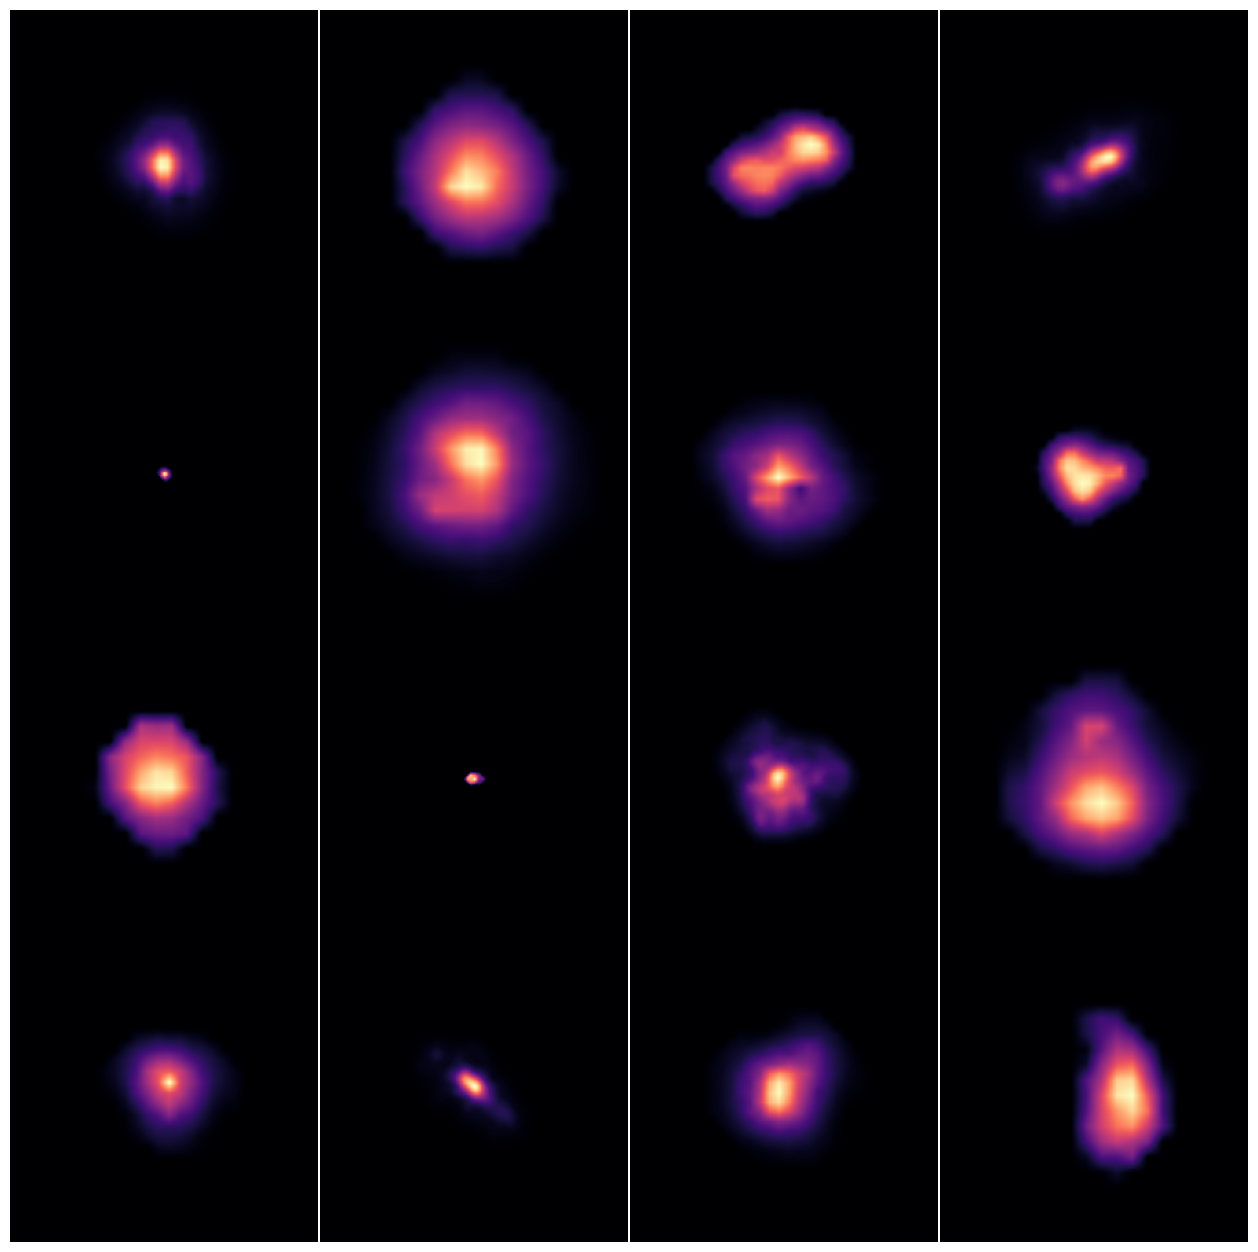

In [47]:
B = 16
band = 2
k = np.random.randint(len(hf["hudf_resized"]) - B)

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        ki = i * 4 + j
        axs[i, j].imshow(hf["hudf_resized"][k+ki, band], cmap="magma")
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

# Fits file dataset

In [71]:
band = "i"
fits.open(fits_files[band][200])[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                   32 / length of data axis 1                          
NAXIS2  =                   32 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CREATOR = 'ShapeLens++'                                                         
BASEFILE= 'h_udf_wfc_i_drz_img.fits' / name of source file                      
ID      =                   45 / object id                                      
XMIN    =                 4942 / min(X) in image pixels                         
YMIN    =                  9

In [72]:
sum([len(v) for v in fits_files.values()])

2245

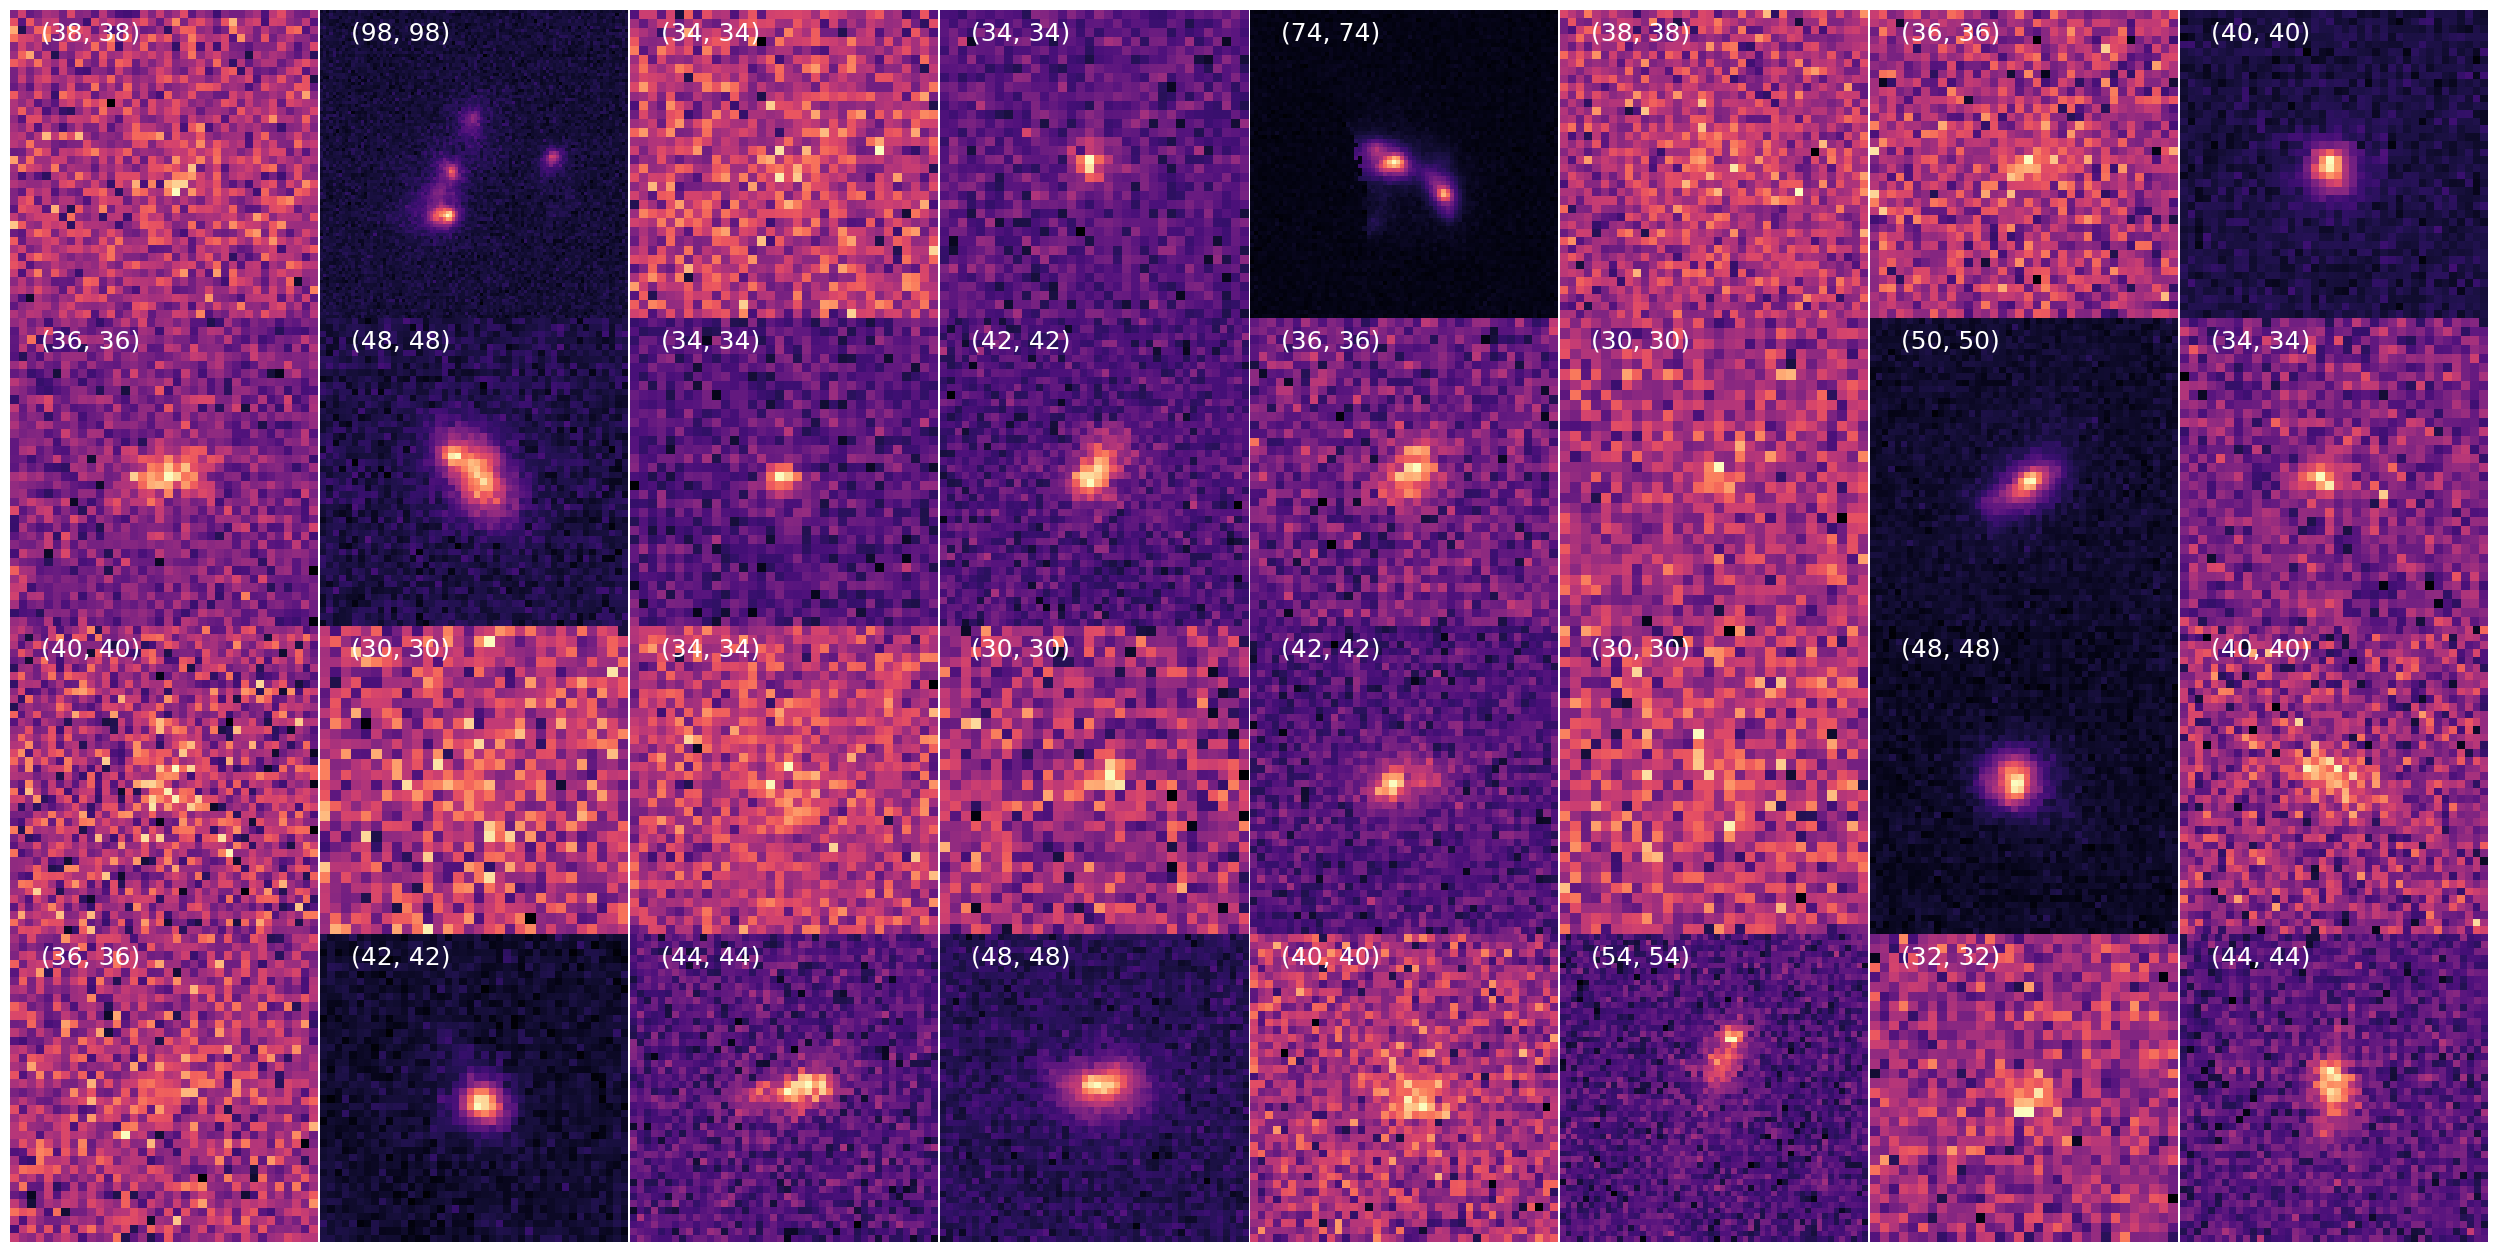

In [50]:
band = "i"
B = 32
k = np.random.randint(len(fits_files[band]) - B)


fig, axs = plt.subplots(4, 8, figsize=(32, 16))
for i in range(4):
    for j in range(8):
        ki = i * 8 + j
        img = fits.open(fits_files[band][k+ki])[0].data
        shape = img.shape
        axs[i, j].imshow(img, cmap="magma")
        axs[i, j].annotate(f"{shape}", xy=(0.1, 0.9), xycoords="axes fraction", color="w", fontsize=18)
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

# Full fits

In [30]:
fs_fits_list = glob.glob(base_path + "full_size/*sci.fits")

In [34]:
data = fits.open(fs_fits_list[-1])
data.info()

Filename: /media/alexandre/Seagate/Data/HST_mag_limited_dataset/full_size/hlsp_xdf_hst_acswfc-30mas_hudf_f606w_v1_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (10500, 10500)   float32   


In [70]:
# data[0].header

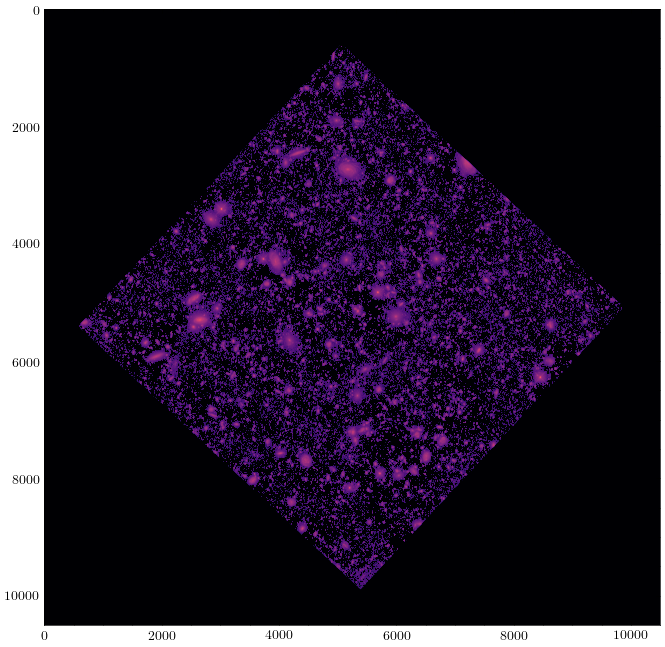

In [64]:
wcs = WCS(data[0].header)

plt.figure(figsize=(8, 8))
# plt.subplot(projection=wcs)
plt.imshow(data[0].data, cmap="magma", norm=plt.cm.colors.LogNorm(vmin=0, vmax=1e4, clip=True))

In [66]:
# Can I estimate the noise structure form this file? I could use SLIC + diffusion to extract information from each files!
N = 30000
img_size = 32
good_crops = []
bad_crops = []

criteria = 1 # percentage of pixel with a flux above 3 sigma
flux_criteria = 3e-4 # less conservative

    
data = fits.open(fs_fits_list[-1])
img = data[0].data
crops = create_random_crops(img, img_size, img_size, N) # correct flux with PAM here
# Ignore cosmic rays, we don't mind them too much. We want to avoid objects that look like signal

for c in crops:
    above_zero = c > 0
    flux = c[above_zero].sum()/img_size**2 
    if (flux < flux_criteria) & np.all(c != 0): # second criteria identifies pixels on the border (a bit conservative but we have lots of crops)
        good_crops.append(c)
    elif (flux != 0): 
        bad_crops.append(c)
    else:
        continue
print(f"{len(good_crops):d} good crops and {len(bad_crops):d} bad crops")

10019 good crops and 1938 bad crops


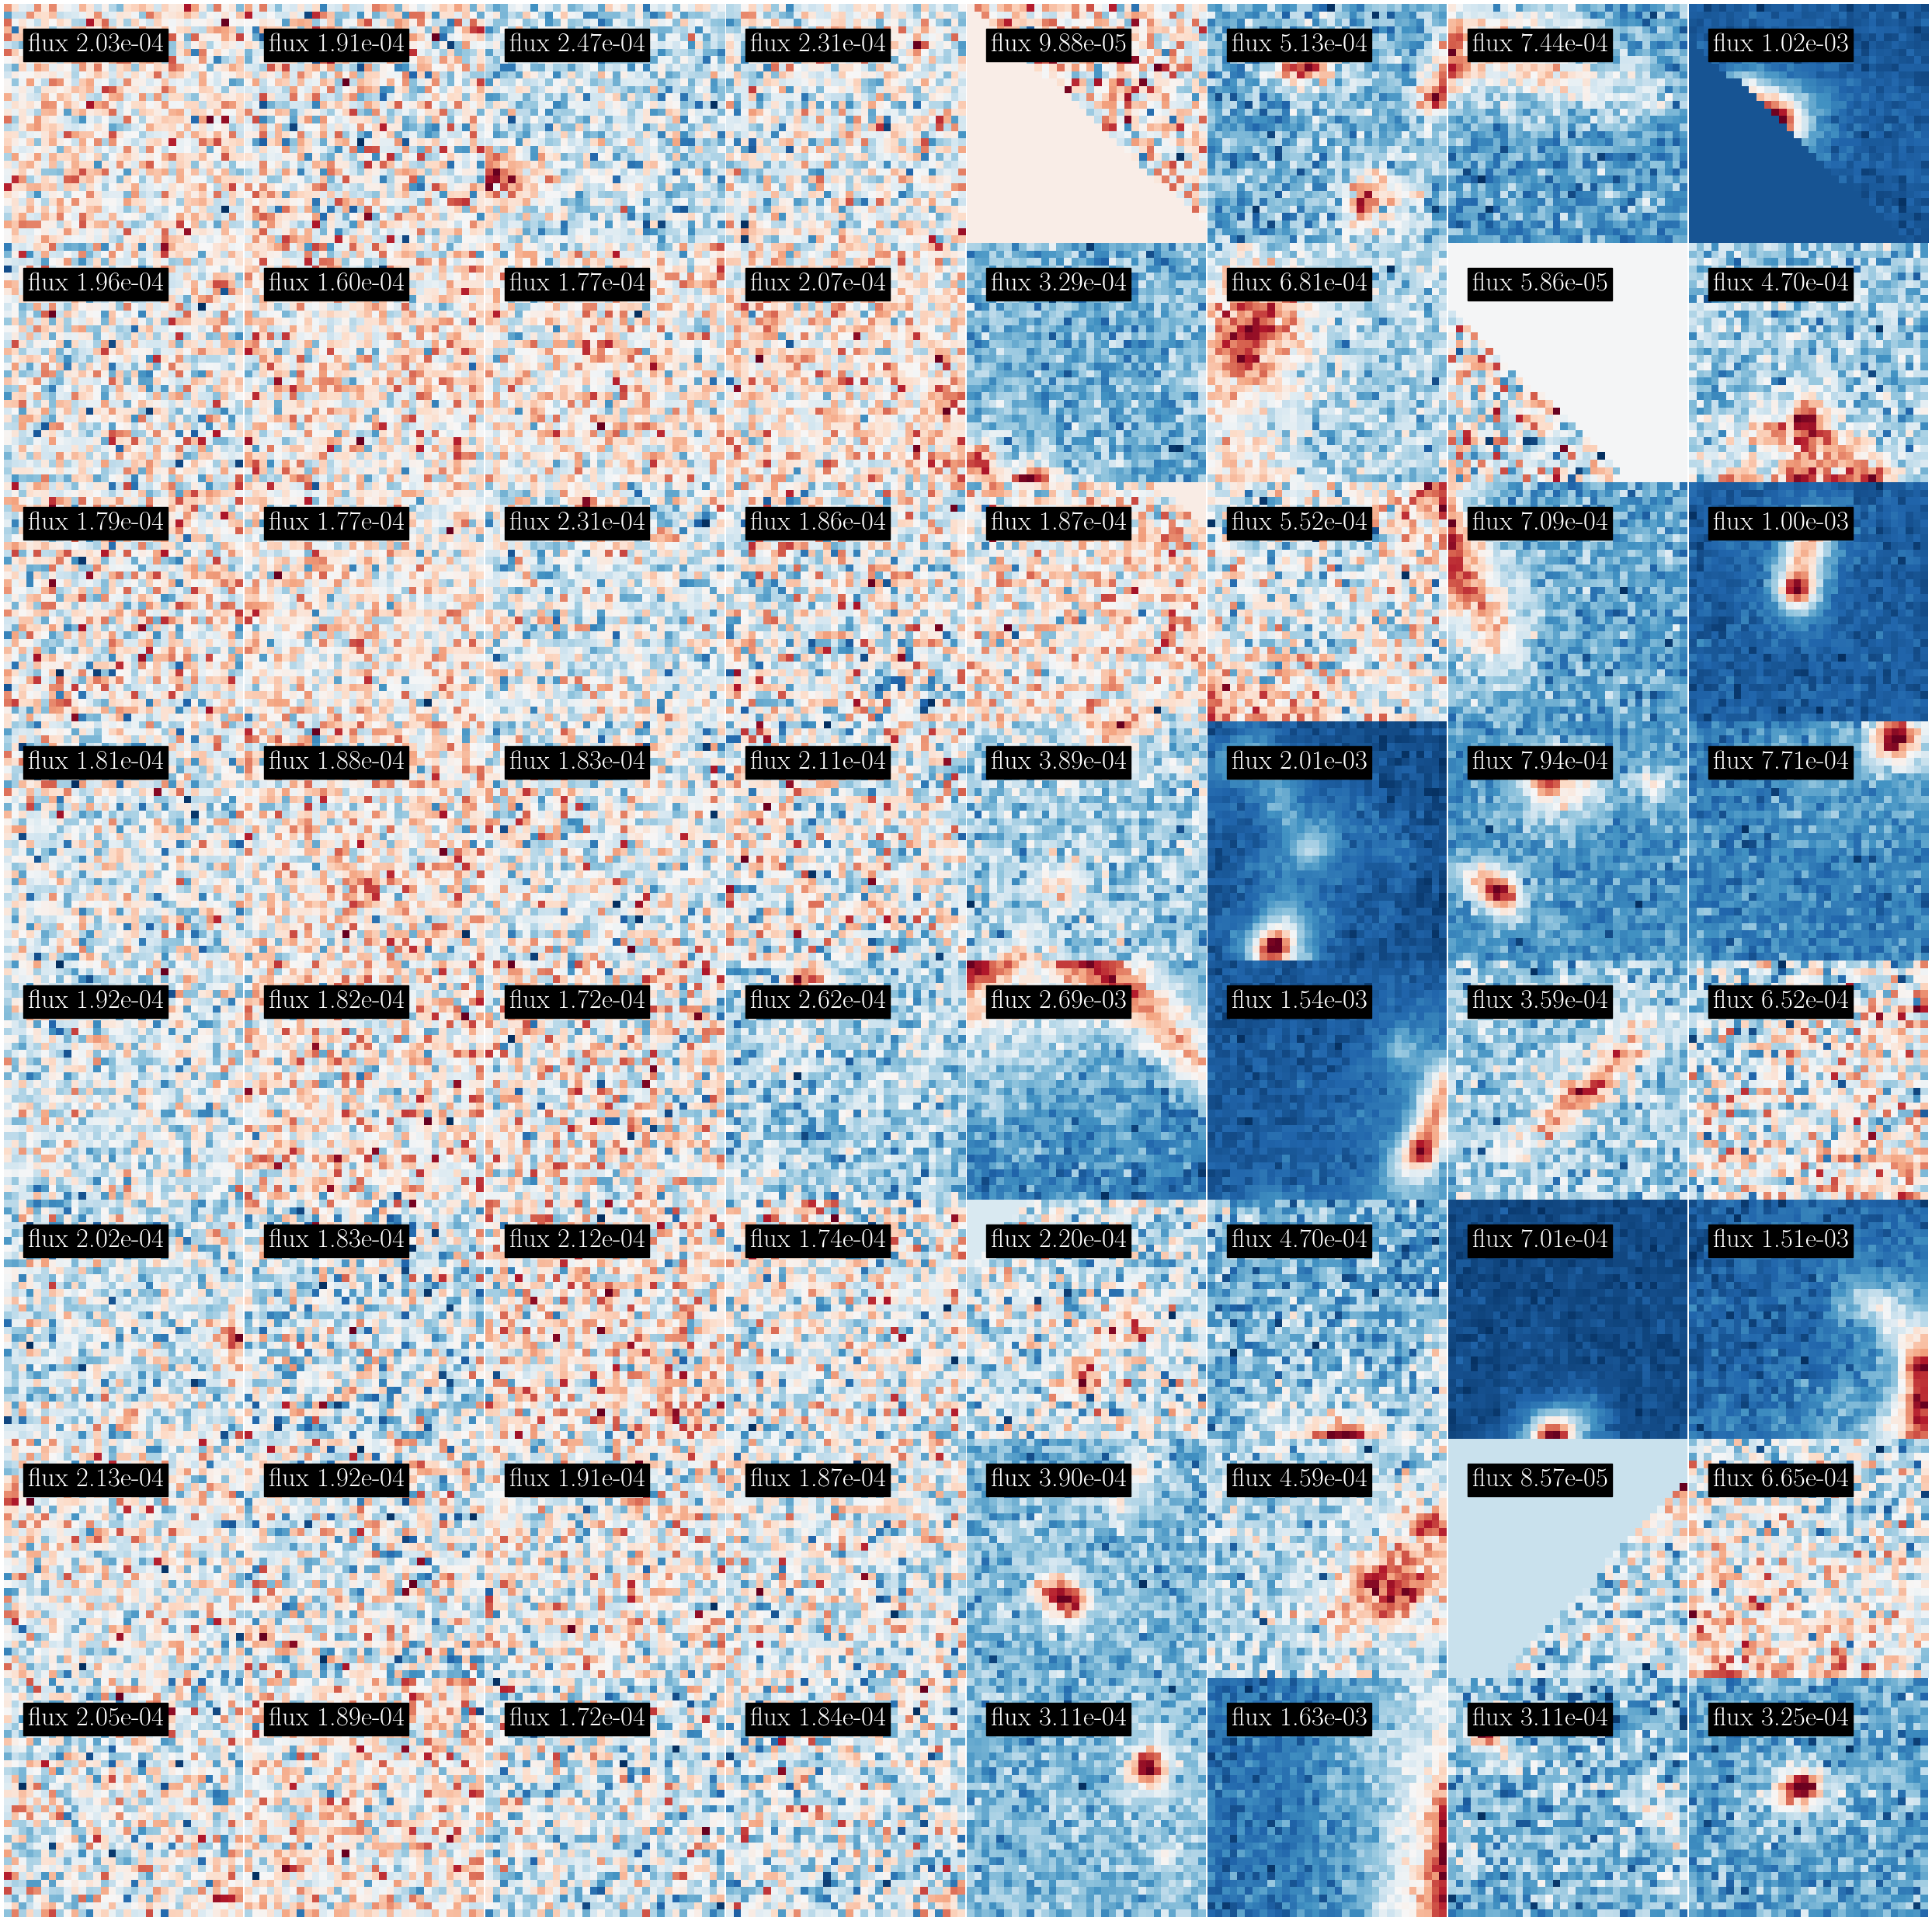

In [68]:
fig, axs = plt.subplots(8, 8, figsize=(32, 32))


for i in range(8):
    for j in range(4):
        k = np.random.randint(len(good_crops))
        above_zero = good_crops[k] > 0
        axs[i, j].imshow(good_crops[k], cmap="RdBu_r")
        axs[i, j].annotate(f"flux {good_crops[k][above_zero].sum()/img_size**2:.2e}", xy=(0.1, 0.8), xycoords="axes fraction", color="w", fontsize=25, backgroundcolor="k")
        axs[i, j].axis("off")
        
    for j in range(4):
        k = np.random.randint(len(bad_crops))
        above_zero = bad_crops[k] > 0
        axs[i, 4+j].imshow(bad_crops[k], cmap="RdBu_r")
        axs[i, 4+j].annotate(f"flux {bad_crops[k][above_zero].sum()/img_size**2:.2e}", xy=(0.1, 0.8), xycoords="axes fraction", color="w", fontsize=25, backgroundcolor="k")
        axs[i, 4+j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

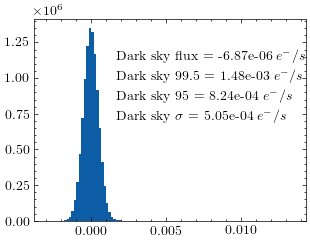

In [91]:
# Maybe a gaussian likelihood can get us going.
px_values = np.stack(good_crops).ravel()

mode = np.quantile(px_values, q=0.5)
three_sigma = np.quantile(px_values, q=0.997)
two_sigma = np.quantile(px_values, q=0.95)
sigma = np.std(px_values)


plt.hist(np.stack(good_crops).ravel(), bins=100)
plt.annotate(r"Dark sky flux = %.2e $e^{-}/s$" % mode, xy=(0.3, 0.8), xycoords="axes fraction")
plt.annotate(r"Dark sky 99.5 = %.2e $e^{-}/s$" % three_sigma, xy=(0.3, 0.7), xycoords="axes fraction")
plt.annotate(r"Dark sky 95 = %.2e $e^{-}/s$" % two_sigma, xy=(0.3, 0.6), xycoords="axes fraction")
plt.annotate(r"Dark sky $\sigma$ = %.2e $e^{-}/s$" % sigma, xy=(0.3, 0.5), xycoords="axes fraction");